In [ ]:
import numpy as np
import pathlib
import gemmi
import scipy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from iotbx.data_manager import DataManager
from iotbx.map_model_manager import map_model_manager
from lib import rmsdcalc
pio.renderers.default = 'notebook'

dm = DataManager()
mmm = map_model_manager()

year = 'year'
system = 'MUREECA'
path_system = pathlib.Path.cwd() / 'data' / 'testdirs' / year / system #path to dataset
path_map = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-event_1_1-BDC_0.24_map.native.ccp4'
path_structure = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-pandda-input.pdb'
path_structure = path_system / 'processing' / 'analysis' / 'initial_model' / f'{system}-x0244' / f'{system}-x0244-pandda-model.pdb'
ccp4_out_name = pathlib.Path.cwd() / 'out1.ccp4'

map = gemmi.read_ccp4_map(str(path_map),setup=True)
grid = map.grid
structure = gemmi.read_structure(str(path_structure))
# frac_box = structure.calculate_fractional_box(margin=1)

def gen_res_dict_for_chain(chain: gemmi.Chain):
    """generates dictionary of residues according one single CHAIN of a structure"""
    residues = {}
    for residue in chain:
        residues[str(residue)] = residue

    return residues

def gen_res_dict_for_structure(structure: gemmi.Structure):
    """
    generates dictionary of for chains in one single model of a structure
    """
    chains = {}
    model = structure[0]
    
    for chain in model:
        residues = gen_res_dict_for_chain(chain)
        chain[str(chain)] = residues

    return chains

def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M

def get_grid_box(map: gemmi.Ccp4Map, 
            residue: gemmi.Residue,
            box_size=10,
            spacing=0.5,
            rand_rot=False,
            plot=False,
            write_map=False):
    
    #calculating centre of mass of residue
    CoM = rmsdcalc.calculate_CoM_residue(residue)
    CoM = CoM
    
    #computing translation vector and matrix
    vec = np.empty(3)
    vec.fill(box_size/2)
    mat = np.identity(3)*spacing

    if rand_rot==True:
        M = rand_rotation_matrix() #random rotation matrix in Cartesian basis
        mat = mat @ M
        vec = M @ vec
        
    min = CoM - vec
    
    min_list = min.tolist()
    mat = mat.tolist()

    tr = gemmi.Transform()
    tr.vec.fromlist(min_list)
    tr.mat.fromlist(mat)

    #interpolating grid
    gridsize = box_size #in Ang
    npoints = int(gridsize / spacing)
    grid_shape = (npoints,npoints,npoints)
    arr = np.zeros(grid_shape, dtype=np.float32)
    map.grid.interpolate_values(arr,tr)

    # plotting
    if plot==True: 
        x,y,z = np.mgrid[0:gridsize/spacing,0:gridsize/spacing,0:gridsize/spacing]
        values = arr.flatten()

        fig = go.Figure(
            
            data=go.Isosurface(
            x=x.flatten(),
            y=y.flatten(),
            z=z.flatten(),
            value=values,
            isomin=0.05,
            isomax=5,
            opacity=0.6,
            surface_count=3

        ))

        fig.show()

    if write_map==True:
        newgrid = gemmi.FloatGrid(*arr.shape)
        newgrid.set_unit_cell(gemmi.UnitCell(10,10,10,90,90,90))
        temp = np.array(newgrid, copy=False)
        temp[:,:,:] = arr[:,:,:]

        ccp4 = gemmi.Ccp4Map()
        ccp4.grid = newgrid
        ccp4.grid.unit_cell.set(10,10,10,90,90,90)
        ccp4.grid.spacegroup = gemmi.SpaceGroup('P1')
        ccp4.update_ccp4_header()
        ccp4.write_ccp4_map(str(ccp4_out_name))

        mm = dm.get_real_map(str(ccp4_out_name))
        mm.set_original_origin_and_gridding(
            original_origin=(min[0]/spacing,min[1]/spacing,min[2]/spacing),
            gridding=grid_shape
        )
        
        mm.show_summary()
        mm.write_map(f'out2_{spacing}.ccp4')

    return arr

chain = structure[0][1]
residues = gen_res_dict_for_chain(chain)
residue = residues['204(PHE)']
arr = get_grid_box(map, residue, box_size=10, plot=True, rand_rot=True)
arr = get_grid_box(map, residue, box_size=10, plot=True)


In [ ]:
import gemmi
import pathlib
import numpy as np
from lib import rmsdcalc
import copy

year = 'year'
system = 'MUREECA'
path_system = pathlib.Path.cwd() / 'data' / 'testdirs' / year / system #path to dataset
path_map = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-event_1_1-BDC_0.24_map.native.ccp4'
path_structure = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-pandda-input.pdb'
ccp4_out_name = pathlib.Path.cwd() / 'outfile.ccp4'

map = gemmi.read_ccp4_map(str(path_map),setup=True)

map_o = gemmi.read_ccp4_map(str(path_map),setup=True)
structure = gemmi.read_structure(str(path_structure))

frac_box = structure.calculate_fractional_box(margin=5)
box = structure.calculate_box(margin=5)
min = box.minimum.tolist()

map.set_extent(frac_box)
map.update_ccp4_header()
grid = map.grid

x = map_o.grid.get_position(1,0,0).tolist()
y = map_o.grid.get_position(0,1,0).tolist()
z = map_o.grid.get_position(0,0,1).tolist()
mat = np.array((x,y,z))
mat = mat.T
mat = mat.tolist()

origin = min

tr = gemmi.Transform()
tr.vec.fromlist(origin)
tr.mat.fromlist(mat)

grid_shape = grid.shape
spacing = grid.spacing
arr_new = np.zeros(grid_shape, dtype=np.float32)
print(grid_shape)

map_o.grid.interpolate_values(arr_new, tr)

temp = np.array(map.grid, copy=False)
temp[:,:,:] = arr_new[:,:,:]

map.write_ccp4_map(str(ccp4_out_name))
print(map.grid.shape)


In [3]:
import copy
import sys
import numpy as np
import pathlib
import gemmi

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'

from lib import extract_box


year = 'year'
system = 'MUREECA'
path_system = pathlib.Path.cwd() / 'data' / 'testdirs' / year / system #path to dataset
path_map = pathlib.Path('/Users/eugene/OneDrive - Nexus365/PhD/4. Rotation 2/code/data/testdirs/year/MUREECA/processing/analysis/panddas/processed_datasets/MUREECA-x0244/MUREECA-x0244-event_1_1-BDC_0.24_map.native.ccp4')
path_structure = path_map.parent / f'{system}-x0244-pandda-input.pdb'
# path_structure = path_system / 'processing' / 'analysis' / 'initial_model' / f'{system}-x0244' / f'{system}-x0244-pandda-model.pdb'
# ccp4_out_name = pathlib.Path.cwd() / 'out1.ccp4'

map = gemmi.read_ccp4_map(str(path_map))
grid = map.grid
structure = gemmi.read_structure(str(path_structure))

residues = {}
chain = structure[0][1]
for residue in chain:
    residues[str(residue)]=residue

residue = residues['204(PHE)']
mask = extract_box.gen_mask_from_atoms(map.grid, residue)
rot_mat = extract_box.rand_rotation_matrix()
vec_rand = extract_box.rand_translations()
array = extract_box.create_numpy_array_with_gemmi_interpolate(residue, mask, rot_mat, vec_rand)
# arr, tr = extract_box.generate_gemmi_transform(residue, rot_mat=rot_mat)


# arr1, tr1 = extract_box.generate_gemmi_transform(residue,rot_mat=rot_mat,vec_rand=vec_rand)
# mask.interpolate_values(arr, tr)
# mask.interpolate_values(arr1,tr1)



#plotting
x,y,z = np.mgrid[0:20,0:20,0:20]
values = array.flatten()
values1 = array.flatten()

print('mask=',mask.axis_order)

# print(arr)

fig1 = go.Figure(
    
    data=go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values,
    isomin=0.05,
    isomax=5,
    opacity=0.6,
    surface_count=3))

fig1.show()

fig = go.Figure(
    
    data=go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values1,
    isomin=0.05,
    isomax=5,
    opacity=0.6,
    surface_count=3))

fig.show()

print(map.grid)
print(grid.nv, grid.nu, grid.nw)
print(grid.shape)
print(type(grid.shape))

AttributeError: module 'lib.extract_box' has no attribute 'rand_rotation_matrix'

In [ ]:
import gemmi
import pathlib
import pandas as pd
from ast import literal_eval
from lib import rmsdcalc

def gen_res_dict_for_chain(chain: gemmi.Chain):
    """generates dictionary of residues according one single CHAIN of a structure"""
    residues = {}
    for residue in chain:
        residues[str(residue)] = residue

    return residues

def gen_res_dict_for_structure(structure: gemmi.Structure):
    """
    generates dictionary of for chains in one single model of a structure
    """
    chains = {}
    model = structure[0]
    
    for chain in model:
        residues = gen_res_dict_for_chain(chain)
        chain[str(chain)] = residues

    return chains




def find_contacts_per_residue(structure: gemmi.Structure, residue: gemmi.Residue, radius=5):
    """function finding contacts close to specific residue"""

    CoM = rmsdcalc.calculate_CoM_residue(residue)
    point = gemmi.Position(CoM[0], CoM[1], CoM[2])

    contacts = []
    ns = gemmi.NeighborSearch(structure[0], structure.cell, radius).populate(include_h=False)
    marks = ns.find_atoms(point, '\0', radius=radius)

    for mark in marks:
        cra = mark.to_cra(structure[0])
        if (cra.residue.name != residue.name) and (cra.residue.het_flag == 'A') \
            and ([mark, cra.chain.name, cra.residue] not in contacts):
            contacts.append([mark, cra.chain.name, cra.residue])
    
    return contacts

def filter_contacts(contacts, rmsd_dict: dict):

    for contact in contacts:
        # remove any residues that have been remodelled according to dict in rmsd.csv
        chain = contact[1]
        residue = str(contact[2])

        if (chain in rmsd_dict.keys()) and residue in rmsd_dict[chain].keys():
            if rmsd_dict[chain][str(residue)] == True:
                print(f'{contact} removed: remodelled residue')
                contacts.remove(contact)
        else:
            print(f'{contact} removed: not in rmsd_dict')
            contacts.remove(contact)

    return contacts



year = 'year'
system = 'MUREECA'
path_system = pathlib.Path.cwd() / 'data' / 'testdirs' / year / system #path to dataset
path_map = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-event_1_1-BDC_0.24_map.native.ccp4'
path_structure = path_system / 'processing' / 'analysis' / 'panddas' / 'processed_datasets' / f'{system}-x0244' / f'{system}-x0244-pandda-input.pdb'
path_structure = path_system / 'processing' / 'analysis' / 'initial_model' / f'{system}-x0244' / f'{system}-x0244-pandda-model.pdb'
ccp4_out_name = pathlib.Path.cwd() / 'out1.ccp4'

rmsd_csv_path = pathlib.Path.cwd() / 'training_data_paths' / year / system / 'rmsd.csv'


st = gemmi.read_structure(str(path_structure))
st.setup_entities()

residues = gen_res_dict_for_chain(st[0][1])
residue = residues['204(PHE)']
dataset = 'MUREECA-x0244'
df = pd.read_csv(rmsd_csv_path)
rmsd_dict = df[df['dataset']==dataset]['remodelled_res'].values[0]
dict = literal_eval(rmsd_dict)

contacts = find_contacts_per_residue(st, residue, radius=5)
print(len(contacts), contacts)
contacts = filter_contacts(contacts, dict)
print(len(contacts), contacts)

# # print(residue)
########### Contact search


In [ ]:

st = gemmi.read_structure(str(path_structure))
st.setup_entities()

# ns = gemmi.NeighborSearch(st[0], st.cell, 10).populate(include_h=False)
ns = gemmi.NeighborSearch(st[0], st.cell, 5).populate(include_h=False)
cs = gemmi.ContactSearch(5.0)
cs.search_radius = 5
cs.ignore = gemmi.ContactSearch.Ignore.SameResidue

results = cs.find_contacts(ns)

len(results)
CRA = results[0].partner1
CRA.residue

list = []
print(len(results))
for result in results:
    chain_p1 = result.partner1.chain.name
    chain_p2 = result.partner2.chain.name
    residue_p1 = result.partner1.residue
    residue_p2 = result.partner2.residue
    if chain_p1 == 'F':
        if str(residue_p1) == str(residue) and [chain_p2, residue_p2] not in list:
            print(chain_p1, residue_p1, chain_p2, residue_p2)
            list.append([chain_p2, residue_p2])
        elif str(residue_p2) == str(residue) and [chain_p1, residue_p1] not in list:
            print(residue_p2)
            list.append([chain_p1, residue_p1])

# print(list)
print(f'len(results={len(results)}')
print(f'len(list)={len(list)}')
print(list)




In [ ]:
import gemmi
import pathlib

mtz_path = pathlib.Path('/Users/eugene/OneDrive - Nexus365/PhD/4. Rotation 2/code/data/testdirs/year/MUREECA/processing/analysis/initial_model/MUREECA-x0244/MUREECA-x0244-pandda-input.mtz')
mtz = gemmi.read_mtz_file(str(mtz_path))
mtz.datasets
two_fofc_grid = mtz.transform_f_phi_to_map('FWT', 'PHWT')
print(two_fofc_grid)



[[-1.3631735  -2.08822363  1.62787279]
 [-2.03811832 -0.49310809  0.16395098]
 [-2.87445996 -0.10382853  0.40162313]
 ...
 [-1.93167286  0.42220192 -1.46946506]
 [ 2.05287508  1.00787186  0.27015869]
 [ 0.61642677  1.14342772  0.37848989]]
<class 'numpy.ndarray'>


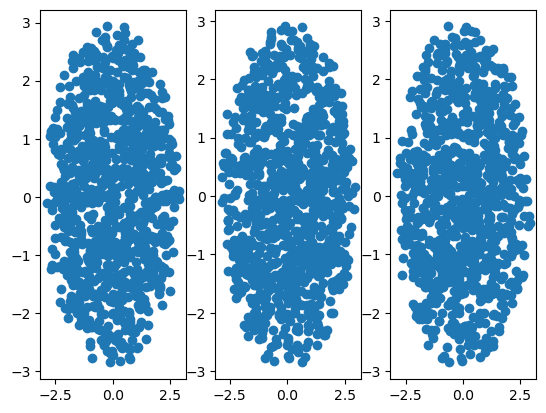

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def rand_translations(R=3):
    phi = np.random.uniform(0,2*np.pi)
    costheta = np.random.uniform(-1,1)
    u = np.random.uniform(0,1)

    theta = np.arccos( costheta )
    r = R * ( u**(1/3) )

    x = r * np.sin( theta) * np.cos( phi )
    y = r * np.sin( theta) * np.sin( phi )
    z = r * np.cos( theta )

    vec_rand = np.array([x,y,z])

    return vec_rand

lst = [3]*1000
vectors = np.array(list((map(rand_translations, lst))))
print(vectors)
print(type(vectors))

plt.subplot(131)
plt.scatter(x=vectors[:,0],y=vectors[:,1])
plt.subplot(132)
plt.scatter(x=vectors[:,1],y=vectors[:,2])
plt.subplot(133)
plt.scatter(x=vectors[:,0], y=vectors[:,2])
plt.show()


In [12]:
import pandas as pd
csv_file = pathlib.Path.cwd().parent / 'training_data_paths' / 'training_data.csv'
df = pd.read_csv(csv_file)

lst = df['event_map'][100]
print(lst)

/Users/eugene/OneDrive - Nexus365/PhD/4. Rotation 2/code/data/testdirs/year/MUREECA/processing/analysis/panddas/processed_datasets/MUREECA-x0244/MUREECA-x0244-event_1_1-BDC_0.24_map.native.ccp4


In [29]:
import gemmi
import pathlib

path_map = pathlib.Path('/Users/eugene/OneDrive - Nexus365/PhD/4. Rotation 2/code/data/testdirs/year/MUREECA/processing/analysis/panddas/processed_datasets/MUREECA-x0244/MUREECA-x0244-event_1_1-BDC_0.24_map.native.ccp4')

map = gemmi.read_ccp4_map(str(path_map))
arr = grid.get_subarray(0,0,0,grid.shape[0],grid.shape[1],grid.shape[2])
print(arr)

[[[ 0.14550324  0.10185055 -0.01854927 ...  0.04392606  0.0665284
    0.12250809]
  [ 0.46689376  0.3728804   0.1421391  ...  0.11235136  0.24166472
    0.401937  ]
  [ 0.62779707  0.5131312   0.22216877 ...  0.01541858  0.25856116
    0.5171581 ]
  ...
  [-0.4761792  -0.50381756 -0.5223824  ... -0.73605275 -0.61527467
   -0.5087279 ]
  [-0.37822378 -0.35360605 -0.35551006 ... -0.5269688  -0.47403094
   -0.42058802]
  [-0.16459727 -0.15876919 -0.19003166 ... -0.19448158 -0.19036464
   -0.17875937]]

 [[-0.07798535 -0.12913515 -0.20117621 ...  0.02825183 -0.00121823
   -0.0370838 ]
  [ 0.2059548   0.06560361 -0.14348623 ...  0.12293646  0.19858694
    0.24226034]
  [ 0.41917765  0.22083361 -0.0964108  ...  0.0689317   0.27583614
    0.4255378 ]
  ...
  [-0.43359753 -0.41851136 -0.4023784  ... -0.6068206  -0.5628983
   -0.49023646]
  [-0.4204266  -0.36406398 -0.3185142  ... -0.41787907 -0.44020322
   -0.4511281 ]
  [-0.29895902 -0.2760529  -0.2566209  ... -0.16191782 -0.21783486
   -0.28